# Notebook for Developing Experiments on CovType Data Set

In [1]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

import pickle
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier


from test_harness.datasets.dataset import Dataset
from test_harness.experiments.baseline_experiment import BaselineExperiment
from test_harness.experiments.topline_experiment import ToplineExperiment
from test_harness.experiments.sqsi_experiment import SQSI_MRExperiment
from test_harness.utils.utils import (
    plot_experiment_error,
    plot_multiple_experiments,
    aggregate_experiment_metrics,
    plot_response_distributions_bysplit,
    format_experimental_scores,
)

%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

## Load Data

In [2]:
with open("../data/covtype_induced_drift_forward.pkl", "rb") as f:
    drift_df, change_points = pickle.load(f)

<IPython.core.display.Javascript object>

In [3]:
drift_df

,elevation,aspect,slope,horizontal_dist_to_hydrology,vertical_dist_to_hydrology,horizontal_dist_to_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,horizontal_dist_to_fire_points,wilderness_area_1,wilderness_area_2,wilderness_area_3,wilderness_area_4,cover_type
0,2836,343,15,190,3,700,188,216,166,1181,0,0,1,0,1
1,2939,174,14,182,27,4590,227,246,148,2665,1,0,0,0,1
2,3181,46,28,582,15,812,216,168,71,1681,0,1,0,0,0
3,3233,123,12,661,29,3030,240,231,120,3024,0,0,1,0,1
4,3023,24,8,531,43,1207,216,222,143,2347,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495136,150,187,33,2963,194,470,241,9,280,2683,1,0,0,0,1
495137,120,201,19,3049,186,871,251,16,244,3129,1,0,0,0,1
495138,283,151,58,3140,208,446,222,9,4,5030,0,1,0,0,1
495139,30,110,3,2939,238,2656,220,12,88,3625,0,1,0,0,1


<IPython.core.display.Javascript object>

**NEED TO**
 - Check distribution of class labels in each "concept" that I've created...

## Experiments

### Prepare Test Harness

In [4]:
# specify columns and if categorical
col_names = [
    ("elevation", False),
    ("aspect", False),
    ("slope", False),
    ("horizontal_dist_to_hydrology", False),
    ("vertical_dist_to_hydrology", False),
    ("horizontal_dist_to_roadways", False),
    ("hillshade_9am", False),
    ("hillshade_noon", False),
    ("hillshade_3pm", False),
    ("horizontal_dist_to_fire_points", False),
]
wilderness_area_cols = [(f"wilderness_area_{i+1}", True) for i in range(4)]
col_names = col_names + wilderness_area_cols + [("cover_type", True)]

<IPython.core.display.Javascript object>

In [5]:
column_mapping = {
    "target": "cover_type",
    "numerical_features": [col for col, iscat in col_names if not iscat],
    "categorical_features": [col for col, iscat in col_names if iscat][:-1],
}

# 17500
CT_dataset = Dataset(
    full_df=drift_df, column_mapping=column_mapping, window_size=17500 * 2
)

model = RandomForestClassifier(n_estimators=5, random_state=42, max_depth=5)
param_grid = {"clf__n_estimators": [3, 5], "clf__max_depth": [3, 5]}

<IPython.core.display.Javascript object>

In [6]:
17500 * 3

52500

<IPython.core.display.Javascript object>

### Run

In [7]:
%%time

baseline = BaselineExperiment(model=model, dataset=CT_dataset, param_grid=param_grid)
baseline.run()

topline = ToplineExperiment(model=model, dataset=CT_dataset, param_grid=param_grid)
topline.run()

sqsi_mr = SQSI_MRExperiment(model=model, dataset=CT_dataset, param_grid=param_grid,  k=10, significance_thresh=0.001)
sqsi_mr.run()

Dataset index of split end: 70000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 0
Shape of k-fold preds: (0,)
Shape of k-fold preds: (3500,)
Shape of k-fold preds: (7000,)
Shape of k-fold preds: (10500,)
Shape of k-fold preds: (14000,)
Shape of k-fold preds: (17500,)
Shape of k-fold preds: (21000,)
Shape of k-fold preds: (24500,)
Shape of k-fold preds: (28000,)
Shape of k-fold preds: (31500,)
FINAL SHAPE kfold preds: (35000,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 1
Dataset Split: 1
REFERENCE STATS: DescribeResult(nobs=35000, minmax=(0.06082224396406262, 0.9553130970093671), mean=0.5716289170237232, variance=0.04525515353122736, skewness=-0.25525888209036446, kurtosis=-1.4490534568632096)
DETECTION STATS: DescribeResult(nobs=35000, minmax=(0.05469761266328168, 0.9364889657412903), mean=0.5724333380906863, variance=0.044133682976263786, skewness=-0.23621441674553992, kurtosis=-1.3691861900180926)
KS Test Result: FAILED | KstestResult(statistic=0.039085714285714335, pvalue=1.15003227647

Shape of k-fold preds: (17500,)
Shape of k-fold preds: (21000,)
Shape of k-fold preds: (24500,)
Shape of k-fold preds: (28000,)
Shape of k-fold preds: (31500,)
FINAL SHAPE kfold preds: (35000,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 9
Dataset Split: 9
REFERENCE STATS: DescribeResult(nobs=35000, minmax=(0.07842966668371384, 0.9198120473267084), mean=0.5700476064945157, variance=0.019014046372067165, skewness=-0.1826292792273725, kurtosis=-0.3701980652311243)
DETECTION STATS: DescribeResult(nobs=35000, minmax=(0.10769287910880401, 0.9030526082735811), mean=0.5705991559579316, variance=0.018434476470900383, skewness=-0.2235907135997959, kurtosis=-0.3804614444108476)
KS Test Result: FAILED | KstestResult(statistic=0.022771428571428554, pvalue=2.580426288931747e-08)

Dataset index of split end: 385000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 9
Shape of k-fold preds: (0,)
Shape of k-fold preds: (3500,)
Shape of k-fold preds: (7000,)
Shape of k-fold preds: (10500,)
Shape of k-fold preds

<IPython.core.display.Javascript object>

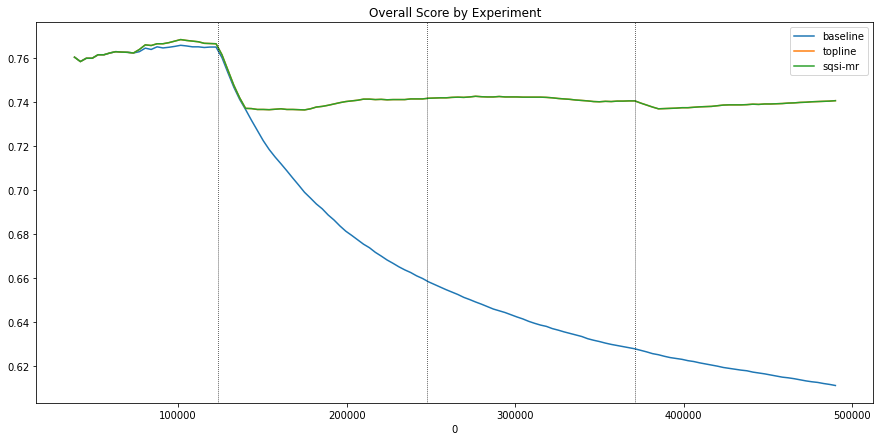

,times_retrained,percent_total_labels,total_train_time
experiment,,,
baseline,1,0.0707,0.16
topline,14,0.9896,1.98
sqsi-mr,14,0.9896,1.95


<IPython.core.display.Javascript object>

In [8]:
exps = [baseline, topline, sqsi_mr]
plot_multiple_experiments(exps, change_points)
aggregate_experiment_metrics(exps)

## SQSI Debug

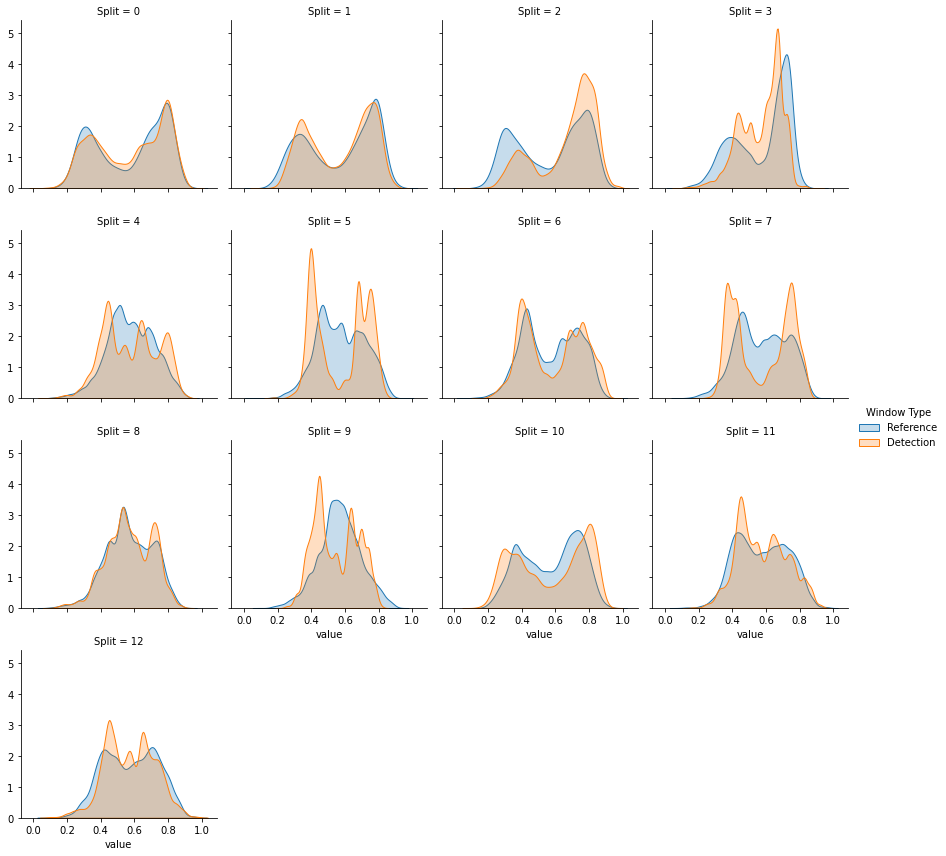

<IPython.core.display.Javascript object>

In [9]:
# @ k = 5
plot_response_distributions_bysplit(sqsi_mr)

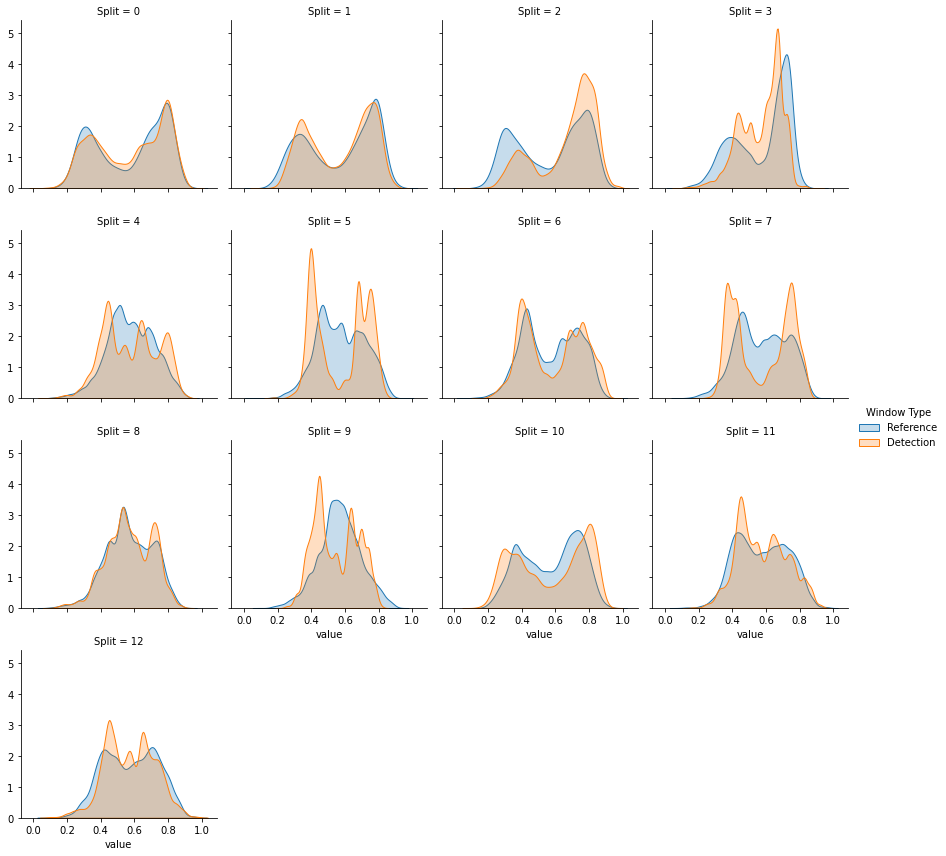

<IPython.core.display.Javascript object>

In [31]:
# @ k = 5
plot_response_distributions_bysplit(sqsi_mr)

In [34]:
calculate_distances_window_distances(sqsi_mr, scipy.stats.entropy)

,Split,Distance
0,0,0.157516
1,1,0.139466
2,2,0.116900
3,3,0.073200
4,4,0.072692
5,5,0.071443
6,6,0.093299
7,7,0.083039
8,8,0.063572
9,9,0.054215


<IPython.core.display.Javascript object>

In [33]:
calculate_distances_window_distances(sqsi_mr, scipy.stats.wasserstein_distance)

,Split,Distance
0,0,0.009110
1,1,0.014873
2,2,0.098546
3,3,0.041194
4,4,0.026446
5,5,0.041569
6,6,0.020963
7,7,0.040058
8,8,0.004096
9,9,0.031281


<IPython.core.display.Javascript object>

In [32]:
calculate_distances_window_distances(sqsi_mr, scipy.spatial.distance.jensenshannon)

,Split,Distance
0,0,0.194725
1,1,0.185078
2,2,0.169473
3,3,0.135201
4,4,0.133278
5,5,0.132565
6,6,0.151304
7,7,0.142964
8,8,0.124812
9,9,0.116194


<IPython.core.display.Javascript object>

In [ ]:
scipy.spatial.distance.jensenshannon()

In [26]:
pd.DataFrame(columns=["a", "b"]).append(pd.DataFrame((1, 2)))

,a,b,0
0,NaN,NaN,1.0
1,NaN,NaN,2.0


<IPython.core.display.Javascript object>

In [ ]:
pd.DataFrame()

### Applying Linear Transformation aka standardizing

In [38]:
# pull a consequtive reference/detection window pair
ref_features, ref_labels = ED_dataset.get_window_data(window_idx=0)
det_features, det_labels = ED_dataset.get_window_data(window_idx=1)

<IPython.core.display.Javascript object>

In [31]:
ref_features

,elevation,aspect,slope,horizontal_dist_to_hydrology,vertical_dist_to_hydrology,horizontal_dist_to_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,horizontal_dist_to_fire_points,wilderness_area_1,wilderness_area_2,wilderness_area_3,wilderness_area_4
0,2836,343,15,190,3,700,188,216,166,1181,0,0,1,0
1,2939,174,14,182,27,4590,227,246,148,2665,1,0,0,0
2,3181,46,28,582,15,812,216,168,71,1681,0,1,0,0
3,3233,123,12,661,29,3030,240,231,120,3024,0,0,1,0
4,3023,24,8,531,43,1207,216,222,143,2347,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,3061,285,14,124,25,1321,181,239,198,2583,0,0,1,0
34996,3189,148,4,85,8,4234,226,239,148,858,0,0,1,0
34997,2298,316,17,192,79,277,174,224,189,618,0,0,0,1
34998,3318,255,20,1057,319,3503,171,248,213,2676,0,0,1,0


<IPython.core.display.Javascript object>

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

<IPython.core.display.Javascript object>

In [35]:
ref_ss = StandardScaler()
ref_ss.fit_transform(ref_features)
ref_ss.mean_, ref_ss.var_

(array([3.00896254e+03, 1.54399971e+02, 1.33951714e+01, 2.75971886e+02,
        4.43293429e+01, 2.51180057e+03, 2.13063171e+02, 2.24557143e+02,
        1.43379029e+02, 2.09797937e+03, 5.08314286e-01, 5.58285714e-02,
        4.29428571e-01, 6.42857143e-03]),
 array([4.11198635e+04, 1.24385546e+04, 4.87240395e+01, 4.63084910e+04,
        3.33659128e+03, 2.47446387e+06, 6.22573809e+02, 3.39087306e+02,
        1.33082994e+03, 1.82213469e+06, 2.49930873e-01, 5.27117420e-02,
        2.45019673e-01, 6.38724490e-03]))

<IPython.core.display.Javascript object>

In [121]:
transformed_det_features = ref_ss.transform(det_features)
transformed_det_ss = StandardScaler().fit(transformed_det_features)

<IPython.core.display.Javascript object>

In [122]:
transformed_det_ss.mean_, transformed_det_ss.var_

(array([ 0.00897751,  0.00738827, -0.02538643,  0.00314849,  0.01058155,
         0.00424083, -0.01170245,  0.01246092,  0.01920807, -0.01688354,
         0.00800034,  0.00087428, -0.00907994,  0.00382187]),
 array([1.02855763, 1.01197278, 0.98789416, 1.02550675, 1.07287191,
        1.02505903, 0.97589156, 0.99522024, 0.98367774, 0.99094778,
        0.99978878, 1.00339761, 0.99749183, 1.04807062]))

<IPython.core.display.Javascript object>

In [118]:
det_ss = StandardScaler().fit(det_features)
det_ss.mean_, det_ss.var_

(array([3.0098933e+03, 1.5471940e+02, 1.3320300e+01, 2.7732960e+02,
        4.4692300e+01, 2.5059952e+03, 2.1289910e+02, 2.2464850e+02,
        1.4369940e+02, 2.0815653e+03, 5.0860000e-01, 5.5600000e-02,
        4.2930000e-01, 6.5000000e-03]),
 array([4.14268807e+04, 1.25142323e+04, 4.85131079e+01, 4.74847086e+04,
        3.55839322e+03, 2.49828164e+06, 6.22247519e+02, 3.32019348e+02,
        1.32476944e+03, 1.80784389e+06, 2.49926040e-01, 5.25086400e-02,
        2.45001510e-01, 6.45775000e-03]))

<IPython.core.display.Javascript object>

#### column transformer

In [39]:
column_transformer = ColumnTransformer(
    [
        ("continuous", StandardScaler(), column_mapping["numerical_features"]),
        ("categorical", "passthrough", column_mapping["categorical_features"]),
    ]
)

<IPython.core.display.Javascript object>

In [40]:
column_transformer.fit(ref_features)

ColumnTransformer(transformers=[('continuous', StandardScaler(),
                                 ['elevation', 'aspect', 'slope',
                                  'horizontal_dist_to_hydrology',
                                  'vertical_dist_to_hydrology',
                                  'horizontal_dist_to_roadways',
                                  'hillshade_9am', 'hillshade_noon',
                                  'hillshade_3pm',
                                  'horizontal_dist_to_fire_points']),
                                ('categorical', 'passthrough',
                                 ['wilderness_area_1', 'wilderness_area_2',
                                  'wilderness_area_3', 'wilderness_area_4'])])

<IPython.core.display.Javascript object>

In [73]:
transformed_ref_features = column_transformer.transform(ref_features)

<IPython.core.display.Javascript object>

In [74]:
transformed_det_features = column_transformer.transform(det_features)

<IPython.core.display.Javascript object>

In [61]:
import seaborn as sns
import numpy as np

<IPython.core.display.Javascript object>

In [94]:
transformed_ref_features[:, 0].shape

(35000,)

<IPython.core.display.Javascript object>

In [143]:
ref_features.iloc[:, 0]

0        2836
1        2939
2        3181
3        3233
4        3023
         ... 
34995    3061
34996    3189
34997    2298
34998    3318
34999    2843
Name: elevation, Length: 35000, dtype: int64

<IPython.core.display.Javascript object>

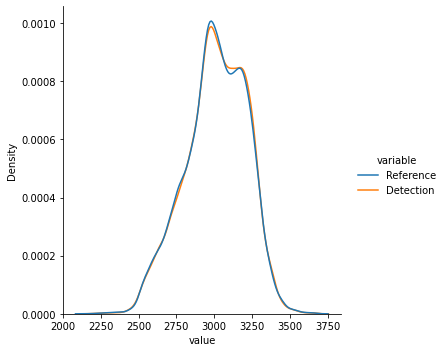

<IPython.core.display.Javascript object>

In [140]:
# original distribution
# transformed distribution
df = pd.DataFrame(
    np.stack(
        [ref_features.iloc[:, 0].to_numpy(), det_features.iloc[:, 0].to_numpy()]
    ).T,
    columns=["Reference", "Detection"],
).melt()

df.value = df.value.astype("float")

sns.displot(data=df, kind="kde", x="value", hue="variable")

In [141]:
ref_features.iloc[:, 0].to_numpy().shape

(35000,)

<IPython.core.display.Javascript object>

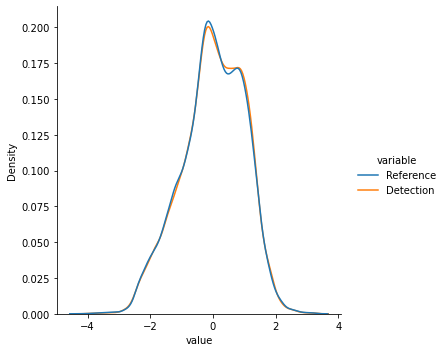

<IPython.core.display.Javascript object>

In [142]:
# transformed distribution
df = pd.DataFrame(
    np.stack([transformed_ref_features[:, 0], transformed_det_features[:, 0]]).T,
    columns=["Reference", "Detection"],
).melt()

df.value = df.value.astype("float")

sns.displot(data=df, kind="kde", x="value", hue="variable")

## What is minimum reference window size for passing KS test?

In [12]:
with open("../data/covtype_nodrift.pkl", "rb") as f:
    nodrift_df = pickle.load(f)

nodrift_df = nodrift_df.reset_index(drop=True)

<IPython.core.display.Javascript object>

In [13]:
CT_nodrift_dataset = Dataset(
    full_df=nodrift_df, column_mapping=column_mapping, window_size=17500 * 5
)

<IPython.core.display.Javascript object>

In [14]:
sqsi_mr_nodrift = SQSI_MRExperiment(
    model=model,
    dataset=CT_nodrift_dataset,
    param_grid=param_grid,
    k=10,
    significance_thresh=0.001,
)
sqsi_mr_nodrift.run()

Dataset index of split end: 175000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 0
Shape of k-fold preds: (0,)
Shape of k-fold preds: (8750,)
Shape of k-fold preds: (17500,)
Shape of k-fold preds: (26250,)
Shape of k-fold preds: (35000,)
Shape of k-fold preds: (43750,)
Shape of k-fold preds: (52500,)
Shape of k-fold preds: (61250,)
Shape of k-fold preds: (70000,)
Shape of k-fold preds: (78750,)
FINAL SHAPE kfold preds: (87500,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 1
Dataset Split: 1
REFERENCE STATS: DescribeResult(nobs=87500, minmax=(0.0687480431472266, 0.9661232413232493), mean=0.5716694540600071, variance=0.044276716703953035, skewness=-0.23478936056525296, kurtosis=-1.4388729888553327)
DETECTION STATS: DescribeResult(nobs=87500, minmax=(0.10440688772904749, 0.9429497475121849), mean=0.5733204625044183, variance=0.04164176792823418, skewness=-0.21044955749902566, kurtosis=-1.4150780727217487)
KS Test Result: FAILED | KstestResult(statistic=0.03832000000000002, pvalue=2.95673802022

<IPython.core.display.Javascript object>

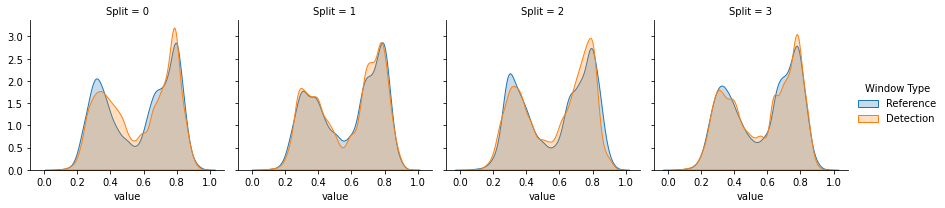

<IPython.core.display.Javascript object>

In [15]:
plot_response_distributions_bysplit(sqsi_mr_nodrift)

In [16]:
tests = [st.ks_2samp, st.cramervonmises_2samp]

for test in tests:
    print(test)

    for i in range(len(sqsi_mr_nodrift.ref_distributions)):

        ref_dist = sqsi_mr_nodrift.ref_distributions[i]
        det_dist = sqsi_mr_nodrift.det_distributions[i]

        res = test(ref_dist, det_dist)

        print(f"TEST: {i} | RESULT: {res}")
        print()

<function ks_2samp at 0x1286493a0>
TEST: 0 | RESULT: KstestResult(statistic=0.03832000000000002, pvalue=2.9567380202285962e-56)

TEST: 1 | RESULT: KstestResult(statistic=0.02572571428571424, pvalue=1.3823876846584186e-25)

TEST: 2 | RESULT: KstestResult(statistic=0.04850285714285707, pvalue=6.963059172080775e-90)

TEST: 3 | RESULT: KstestResult(statistic=0.023942857142857155, pvalue=3.214370778385961e-22)

<function cramervonmises_2samp at 0x12862a940>
TEST: 0 | RESULT: CramerVonMisesResult(statistic=14.221517444933852, pvalue=7.633721432753759e-10)

TEST: 1 | RESULT: CramerVonMisesResult(statistic=2.5656891260405246, pvalue=6.957841539589893e-07)

TEST: 2 | RESULT: CramerVonMisesResult(statistic=17.650736465500813, pvalue=1.580650610399914e-09)

TEST: 3 | RESULT: CramerVonMisesResult(statistic=2.978069244087237, pvalue=8.462349765370192e-08)



<IPython.core.display.Javascript object>

In [18]:
for i in range(len(sqsi_mr_nodrift.ref_distributions)):

    ref_dist = sqsi_mr_nodrift.ref_distributions[i]
    det_dist = sqsi_mr_nodrift.det_distributions[i]

    res = scipy.spatial.distance.jensenshannon(ref_dist, det_dist)

    print(f"TEST: {i} | RESULT: {res}")
    print()

TEST: 0 | RESULT: 0.1894512044789658

TEST: 1 | RESULT: 0.18520725355566742

TEST: 2 | RESULT: 0.19148075683690122

TEST: 3 | RESULT: 0.1862519246527628



<IPython.core.display.Javascript object>

**It looks like Kologorov-Smirnov is too sensitive/strict for our use case**

"A test has told you that two samples aren't from literally identical populations, but that's not what you actually care about. What you actually care about is up to you; it sounds like you care about how different the populations are. The solution is not to try to transform 𝑝-values ("when all you have is a hammer", etc.) but to use a more appropriate technique."

In [106]:
res.statistic

0.023942857142857155

<IPython.core.display.Javascript object>

In [10]:
import numpy as np
import scipy.stats as st
import scipy

#generate random aray
samp_a = sqsi_mr_nodrift.ref_distributions[1]


#generate random samples from lognormal and sort
samp_b = sqsi_mr_nodrift.det_distributions[1]


#concatenate and sort
samp_conc = np.sort(np.concatenate((samp_a, samp_b)))


#cdf of sample a
samp_a_cdf = [np.round(st.percentileofscore(samp_a, value)/100, 1) for value in samp_conc]


#cdf of sample b
samp_b_cdf = [np.round(st.percentileofscore(samp_b, value)/100, 1) for value in samp_conc]


#compute absolute difference
samp_diff = np.abs(np.subtract(samp_a_cdf, samp_b_cdf))


NameError: name 'sqsi_mr_nodrift' is not defined

<IPython.core.display.Javascript object>

In [118]:
samp_a

array([0.72742698, 0.60192602, 0.71006694, ..., 0.86829782, 0.48057593,
       0.2780656 ])

<IPython.core.display.Javascript object>

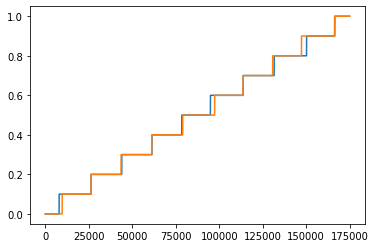

<IPython.core.display.Javascript object>

In [116]:
plt.plot(samp_a_cdf)
plt.plot(samp_b_cdf)

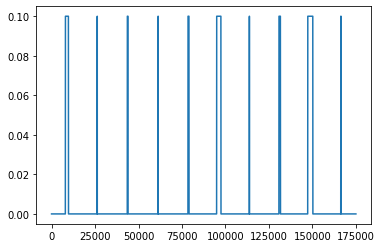

<IPython.core.display.Javascript object>

In [104]:
plt.plot(samp_diff)

In [ ]:
1.36